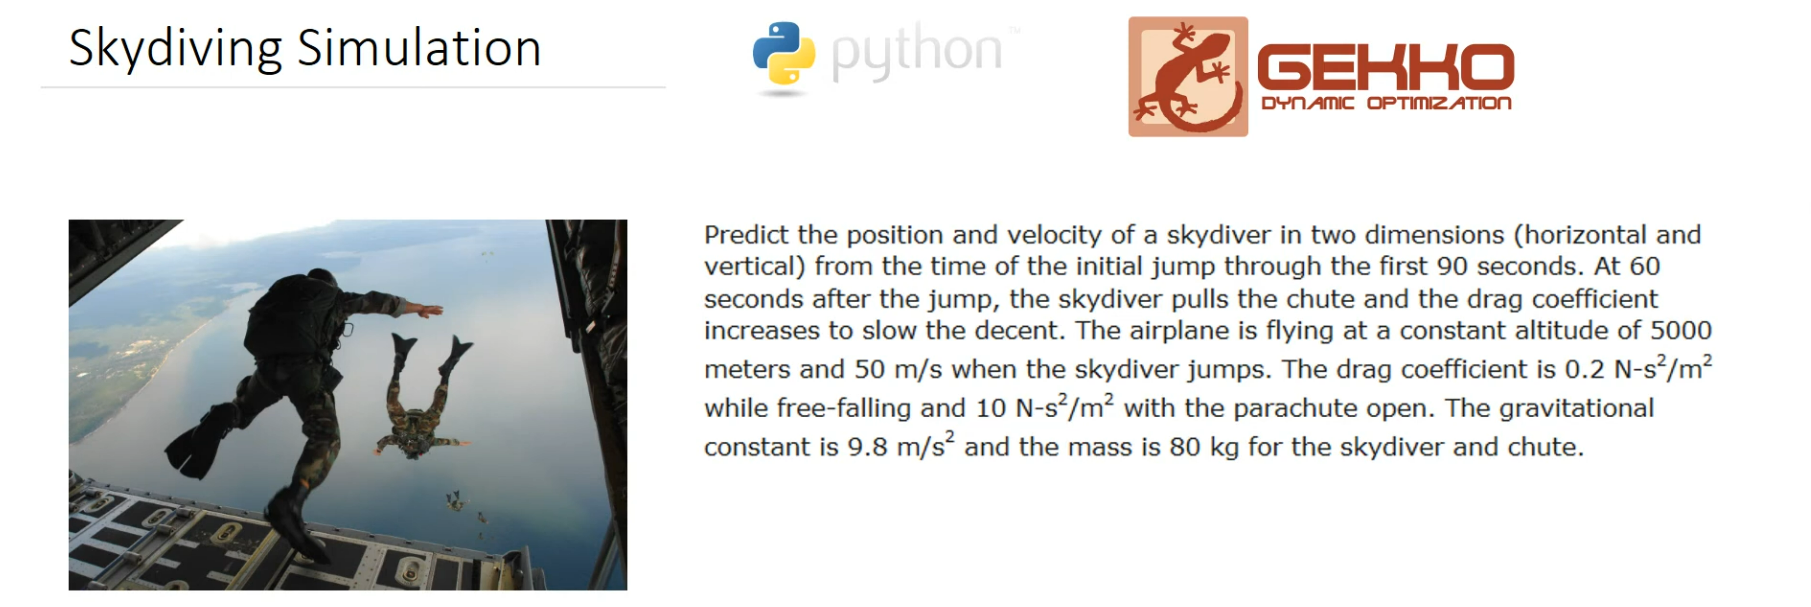

# Equations
- Momentum balance:

$ F_x = -d * {V_x}^2$ (1)

$ F_y = -mass*g + d * {V_y}^2$ (2)

- Kinematics:
  
$F_x / mass = dV_x/dt$ (3)

$F_y / mass = dV_y/dt$ (4)


- Combining (1) and (3): 
  
$mass * dV_x/dt = -d * {V_x}^2$ (5);


- Combining (2) and (4):  

$mass * dV_y/dt = -mass*g + d * {V_y}^2$ (6);


- Velocity components:

$ dx/dt = V_x $ (7)

$ dy/dt = V_y $ (8)

- Total velocity:
$ V = \sqrt{{V_x}^2 + {V_y}^2} $ (9)

-> Equations (5), (6), (7), and (8) form a system of four first-order ordinary differential equations (ODEs) that can be solved numerically.

- Drag coefficient:
d = 0.2 $N-s^2/m^2$ while free-falling and 10 $N-s^2/m^2$ while parachuting.

- Initial conditions:
At t = 0 s:
h = 5000 $m$;
Vx = 50 $m/s$;
Vy = 0 $m/s$;
m = 80 $kg$;
g = 9.81 $m/s^2$;

In [1]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Using Gekko to solve the ODEs

In [7]:
# Number of points in time discretization
n = 91
 # Initialize model
m = GEKKO(remote=False)

# Define time discretization
m.time = np.linspace(0,90,n)

# make array of drag coefficients, changing at time 60
drag = [ (0.2 if t<=60 else 10.0) for t in m.time]

# Define constants
g = m.Const(value=9.81)  # gravity (m/s^2)
mass = m.Const(value=80.0)  # mass of skydiver (kg)

# Define drag parameter
d = m.Param(value=drag)

# Initialize variables
x,y,vx,vy,v,Fx,Fy = [m.Var(value=0) for _ in range(7)]

# Intial conditions
y.value = 5000  # initial altitude (m)
vx.value = 50    # initial horizontal velocity (m/s)

In [8]:
# Equations
# Force balance
m.Equation(Fx == -d*vx**2)
m.Equation(Fy == -mass*g + d*vy**2)
# F = m*a
m.Equation(Fx / mass == vx.dt())
m.Equation(Fy / mass == vy.dt())
# Velocity definitions
m.Equation(vx == x.dt())
m.Equation(vy == y.dt())
# Total velocity
m.Equation(v == (vx**2 + vy**2)**0.5)
# Set global options
m.options.IMODE = 4  # dynamic simulation

In [9]:
# Solve simulation
m.solve()

 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  2
   Variables    :  8
   Intermediates:  0
   Connections  :  0
   Equations    :  7
   Residuals    :  7
 
 Number of state variables:    990
 Number of total equations: -  990
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
        

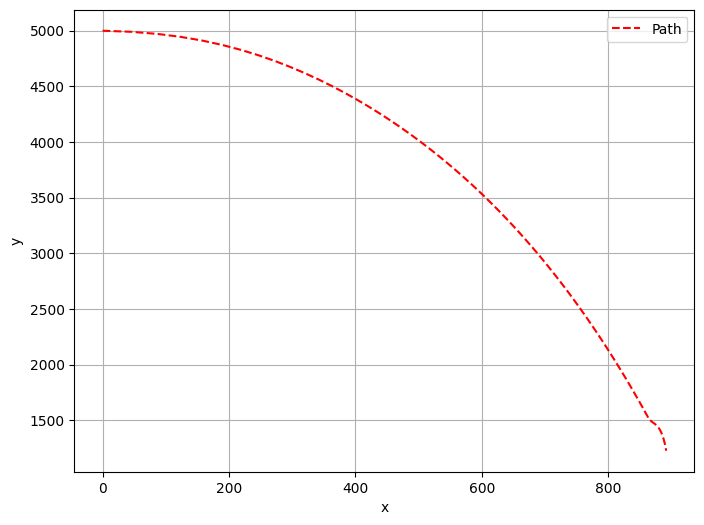

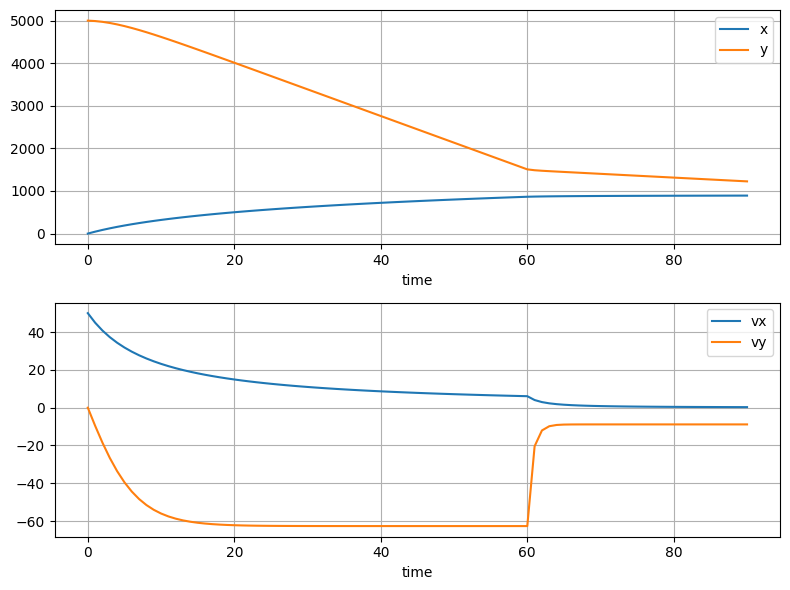

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x.value, y.value, 'r--', label='Path')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()

fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(m.time, x.value, label='x')
ax1.plot(m.time, y.value, label='y')    
ax1.set_xlabel('time')
ax1.grid()
ax1.legend()
ax2.plot(m.time, vx.value, label='vx')
ax2.plot(m.time, vy.value, label='vy')
ax2.set_xlabel('time')
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.show()

# Solve using Scipy ODEINT

In [2]:
def skydive(z,t):
    # constants
    g = 9.81 # m/s^2, gravitational constant
    m = 80   # kg, mass of skydiver and pack
    if t<61:
        c = 0.2  # N-s^2/m^2, drag coefficient, chute closed
    else:
        c = 10.0 # N-s^2/m^2, drag coefficient, chute open

    # states (z)
    x = z[0]  # meters, horizontal position 
    y = z[1]  # meters, vertical position / elevation
    vx = z[2] # m/s, skydiver horizontal velocity = airplane velocity
    vy = z[3] # m/s, skydiver vertical velocity

    # derived values
    v = np.sqrt(vx**2+vy**2) # m/s, magnitude of velocity
    Fx = -c * vx**2
    Fy = -m*g + c*vy**2

    # calculate derivatives
    dxdt = vx
    dydt = vy
    dvxdt = Fx / m
    dvydt = Fy / m
    dzdt = [dxdt,dydt,dvxdt,dvydt]    

    return dzdt

# initial conditions
z0 = [0,5000,50,0]
# time points
t = np.linspace(0,90,91)
# solve
z1 = odeint(skydive,z0,t)

# parse results
x = z1[:,0]
y = z1[:,1]
vx = z1[:,2]
vy = z1[:,3]
v = np.sqrt(vx**2+vy**2)

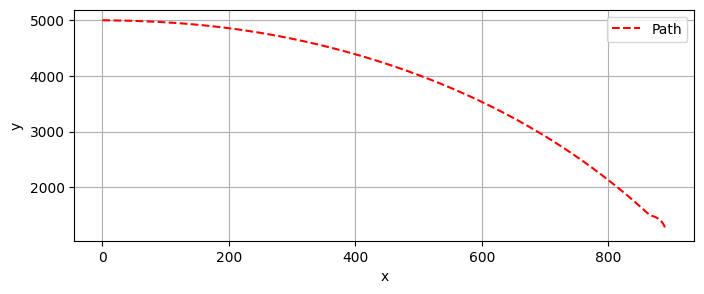

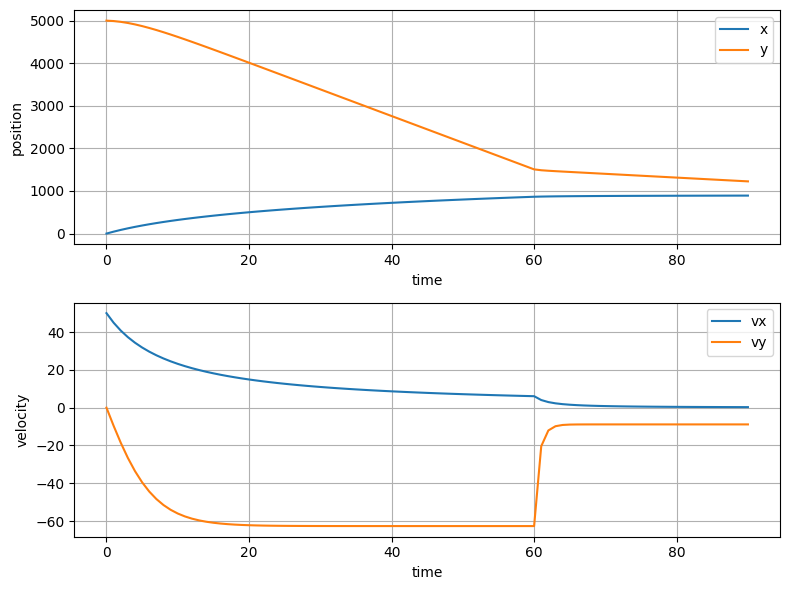

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, 'r--', label='Path')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()

fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(t, x, label='x')
ax1.plot(t, y, label='y')    
ax1.set_xlabel('time')
ax1.set_ylabel('position')
ax1.grid()
ax1.legend()
ax2.plot(t, vx, label='vx')
ax2.plot(t, vy, label='vy')
ax2.set_xlabel('time')
ax2.set_ylabel('velocity')
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.show()